In [ ]:
engine_path=r"stockfish\stockfish-windows-x86-64-avx2.exe"
import pandas as pd
import chess
import chess.pgn
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical

In [ ]:
def load_chess_games(pgn_file_path):
    games_data = []
    with open(pgn_file_path) as pgn:
        while True:
            game = chess.pgn.read_game(pgn)
            if game is None:
                break
            
            # Extract game information
            game_info = {
                'White': game.headers.get("White"),
                'Black': game.headers.get("Black"),
                'Result': game.headers.get("Result"),
                'Moves': ' '.join(str(move) for move in game.mainline_moves())
            }
            
            games_data.append(game_info)

    # Create a DataFrame from the list of game data
    return pd.DataFrame(games_data)

In [ ]:
init_df=load_chess_games(r"lichess_db_standard_rated_2013-11.pgn") #testing with existing games
#it will change with the player's data
init_df.head()


White          Black Result  \
0  saintglinglin      RootsGora    0-1   
1      bearrr123  augustus_hill    1-0   
2        Process   faulschlamm1    0-1   
3        Roman58          JoBaR    1-0   
4       gdfbvnvb            pun    0-1   

                                               Moves  
0  e2e4 e7e5 g1f3 d7d6 d2d4 g8f6 b1c3 c8d7 f1e2 a...  
1  d2d3 g7g6 e2e4 f8g7 b1c3 b8c6 c1e3 e7e6 d1d2 d...  
2  e2e4 g8f6 e4e5 f6d5 c2c4 d5b6 d2d4 d7d6 g1f3 d...  
3  e2e4 d7d5 e4d5 d8d5 b1c3 d5d4 g1f3 d4d8 f1c4 e...  
4  d2d4 e7e6 c2c4 c7c5 b1c3 g8f6 d4c5 f8c5 e2e4 e...

In [ ]:
data=init_df["Moves"]

# Tokenization
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

# Prepare input-output pairs
sequence_length = 5 # Define how many moves to consider as input
X = []
y = []
for seq in sequences:
    for i in range(sequence_length, len(seq)):
        X.append(seq[i-sequence_length:i])
        y.append(seq[i])

X = np.array(X)
y = np.array(y)

# One-hot encode output
y = to_categorical(y, num_classes=vocab_size)

# Build the LSTM model
model = Sequential([
    Embedding(vocab_size, 64, input_length=sequence_length),
    LSTM(128, return_sequences=False),
    Dense(vocab_size, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history=model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2)

# Save the model
model.save("chess_move_predictor.h5")

with open("tokenizer.pkl", "wb") as file:
    pickle.dump(tokenizer, file)

Epoch 1/50


c:\Users\yassi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.0089 - loss: 6.2731 - val_accuracy: 0.0000e+00 - val_loss: 6.2772
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0198 - loss: 6.2521 - val_accuracy: 0.0108 - val_loss: 6.3190
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0096 - loss: 6.1199 - val_accuracy: 0.0108 - val_loss: 6.8964
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0121 - loss: 5.8428 - val_accuracy: 0.0054 - val_loss: 7.2693
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0132 - loss: 5.7333 - val_accuracy: 0.0108 - val_loss: 7.3390
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0062 - loss: 5.6701 - val_accuracy: 0.0108 - val_loss: 7.9354
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0042 - loss: 5.5422 - val_accuracy: 0.0054 - val_loss: 7.9037
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0165 - loss: 5.4911 - val_accuracy: 0.0054 - val_loss: 8

In [ ]:

# Load the model
model = load_model("chess_move_predictor.h5")

# Load the tokenizer
with open("tokenizer.pkl", "rb") as file:
    tokenizer = pickle.load(file)

# Example input moves
input_moves = "e2e4 e7e5 g1f3".split()
input_seq = tokenizer.texts_to_sequences([" ".join(input_moves)])[0]
input_seq = pad_sequences([input_seq], maxlen=5)  # Adjust sequence_length if needed

# Predict the next move
predicted = model.predict(input_seq)
predicted_move_index = np.argmax(predicted)
predicted_move = tokenizer.index_word[predicted_move_index]

print(f"Predicted next move: {predicted_move}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Predicted next move: e3g5


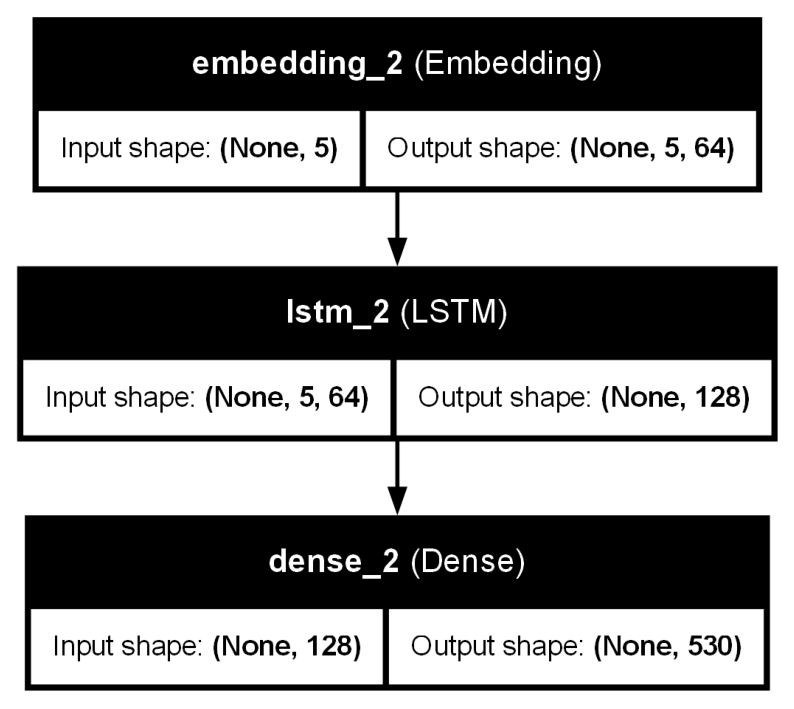

In [21]:
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

# Visualize the model architecture
plot_model(
    model,
    to_file="model_visualization.png",
    show_shapes=True,  # Show input/output tensor shapes
    show_layer_names=True  # Show layer names
)

# Display the visualization
img = plt.imread("model_visualization.png")
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.show()


In [ ]:

# Step 1: Preprocessing
def preprocess_data_for_game_outcome(df):
    # Tokenize moves
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(df['Moves'].tolist())
    vocab_size = len(tokenizer.word_index) + 1

    # Convert moves to sequences
    sequences = tokenizer.texts_to_sequences(df['Moves'])
    max_len = max(len(seq) for seq in sequences)
    X = pad_sequences(sequences, maxlen=max_len, padding='post')

    # Prepare labels
    y = df['Result'].map({-1: 0, 0: 1, 1: 2}).values  # Map -1, 0, 1 to 0, 1, 2
    y = to_categorical(y, num_classes=3)  # One-hot encode labels

    return X, y, vocab_size, max_len, tokenizer

# Step 2: Define the LSTM Model
def build_lstm_model(vocab_size, max_len, embed_dim=64, hidden_dim=128):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_len),
        LSTM(hidden_dim, return_sequences=False),
        Dense(3, activation='softmax')  # 3 output classes: -1, 0, 1
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Step 3: Training the Model
def train_lstm_model(df, model_path="chess_lstm.h5"):
    # Preprocess the data
    X, y, vocab_size, max_len, tokenizer = preprocess_data_for_game_outcome(df)

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


    model = build_lstm_model(vocab_size, max_len)

    # Train the model
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

    # Save the model and tokenizer
    model.save(model_path)

    with open('tokenizer.pkl', 'wb') as f:
        pickle.dump(tokenizer, f)

    print(f"Model saved to {model_path}")
    return model, tokenizer

# Step 4: Predict Outcome
def predict_outcome(model, tokenizer, moves):
    # Tokenize and pad input
    sequence = tokenizer.texts_to_sequences([moves])
    sequence = pad_sequences(sequence, maxlen=model.input_shape[1], padding='post')

    # Predict
    prediction = model.predict(sequence)
    outcome = np.argmax(prediction, axis=1)[0]  # Decode one-hot output
    outcome_map = {0: -1, 1: 0, 2: 1}
    return outcome_map[outcome]




In [ ]:
game_res={-1:"win",1:"draw",2:"lost"}
# Train the model
model, tokenizer = train_lstm_model(init_df)



Epoch 1/10


c:\Users\yassi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.0833 - loss: 1.1061 - val_accuracy: 1.0000 - val_loss: 1.0372
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 1.0000 - loss: 1.0447 - val_accuracy: 1.0000 - val_loss: 0.9620
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 1.0000 - loss: 0.9796 - val_accuracy: 1.0000 - val_loss: 0.8693
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 1.0000 - loss: 0.8996 - val_accuracy: 1.0000 - val_loss: 0.7462
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 0.7936 - val_accuracy: 1.0000 - val_loss: 0.5775
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 0.6486 - val_accuracy: 1.0000 - val_loss: 0.3563
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 0.4571 - val_accuracy: 1.0000 - val_loss: 0.1345
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 0.2580 - val_accuracy: 1.0000 - val_loss: 0.0278
Epoch 

Model saved to chess_lstm.h5


In [24]:
game_result={-1:"lost",0:"win",1:"draw"}
# Predict outcome
moves = "e2e4 e7e5 g1f3"
result = predict_outcome(model, tokenizer, moves)
print(f"Predicted outcome: {game_result[result]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
Predicted outcome: win
